In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# I. Load Data

In [2]:

df=pd.read_csv(r'C:\Users\DO TUAN MINH\Desktop\ben\Learn\Project\demo_data\final.csv')

In [3]:
df=df.drop(columns=['D THU'])

In [4]:
df = df.dropna().reset_index(drop=True)


In [5]:
x=df.drop(columns=['revenue','date'])
y=df['revenue']


In [6]:
weekday_columns = ['weekday_Monday', 'weekday_Tuesday', 'weekday_Wednesday', 'weekday_Thursday', 'weekday_Friday', 'weekday_Saturday', 'weekday_Sunday']
df[weekday_columns] = df[weekday_columns].astype(int)


In [7]:
df.count

<bound method DataFrame.count of            date  weekday_Friday  weekday_Monday  weekday_Saturday  \
0    2023-01-08               0               0                 0   
1    2023-01-09               0               1                 0   
2    2023-01-10               0               0                 0   
3    2023-01-11               0               0                 0   
4    2023-01-12               0               0                 0   
..          ...             ...             ...               ...   
308  2023-12-26               0               0                 0   
309  2023-12-28               0               0                 0   
310  2023-12-29               1               0                 0   
311  2023-12-30               0               0                 1   
312  2023-12-31               0               0                 0   

     weekday_Sunday  weekday_Thursday  weekday_Tuesday  weekday_Wednesday  \
0                 1                 0                0       

In [8]:
df.dtypes

date                       object
weekday_Friday              int32
weekday_Monday              int32
weekday_Saturday            int32
weekday_Sunday              int32
weekday_Thursday            int32
weekday_Tuesday             int32
weekday_Wednesday           int32
totalprecip_mm            float64
avgvis_km                 float64
temp_c                    float64
wind_kph                  float64
pressure_in               float64
humidity                    int64
revenue                   float64
revenue_prev1             float64
revenue_prev2             float64
revenue_mean_3            float64
revenue_mean_7            float64
revenue_diff              float64
revenue_pct_change        float64
revenue_dev_from_mean7    float64
dtype: object

In [42]:

df['date'] = pd.to_datetime(df['date'])
df['month']=df['date'].dt.month

# Tạo các cột mùa
df['is_spring'] = df['month'].isin([2, 3, 4]).astype(int)
df['is_summer'] = df['month'].isin([5, 6, 7]).astype(int)
df['is_autumn'] = df['month'].isin([8, 9, 10]).astype(int)
df['is_winter'] = df['month'].isin([11, 12, 1]).astype(int)

df=df.drop(columns='month')

In [57]:
# # Giả sử bạn có cột 'date' kiểu datetime trong DataFrame df
# df['date'] = pd.to_datetime(df['date'])

# Tạo các cột ngày cuối tuần (Thứ 7, Chủ nhật)
df['is_weekend'] = df['date'].dt.weekday.isin([5, 6]).astype(int)

# Tạo cột cho các ngày lễ ngắn (30/4, 1/5, 2/9, 1/1)
short_holidays = [(1, 1), (4, 30), (5, 1), (9, 2)]  # (tháng, ngày)
df['is_short_holiday'] = df['date'].apply(lambda x: 1 if (x.month, x.day) in short_holidays else 0)


# II. Training models

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Lọc các cột số, trừ cột target 'revenue' và các cột one-hot weekday
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
exclude_columns = ['revenue'] + ['weekday_Monday', 'weekday_Tuesday', 'weekday_Wednesday',
                                 'weekday_Thursday', 'weekday_Friday', 'weekday_Saturday', 'weekday_Sunday']
numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

# Chia dữ liệu thành train/test
X = df.drop(columns=['revenue', 'date'])  # X là các đặc trưng (features)
y = df['revenue']  # y là target (doanh thu)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tạo đối tượng StandardScaler và chỉ fit trên dữ liệu huấn luyện
scaler = StandardScaler()

# Fit scaler trên tập huấn luyện và transform trên cả tập huấn luyện và kiểm tra


X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled = scaler.transform(X_test[numeric_columns])

# Chuyển lại thành DataFrame với cột giống như ban đầu
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_columns, index=X_test.index)


# Gộp lại với các cột không phải số
X_train_final = X_train.drop(columns=numeric_columns).join(X_train_scaled)
X_test_final = X_test.drop(columns=numeric_columns).join(X_test_scaled)

# Kiểm tra dữ liệu sau khi scale
print(X_train_final.head())
print(X_test_final.head())


     weekday_Friday  weekday_Monday  weekday_Saturday  weekday_Sunday  \
90                0               0                 0               0   
218               0               0                 1               0   
256               0               0                 0               0   
137               0               0                 0               0   
204               0               0                 0               0   

     weekday_Thursday  weekday_Tuesday  weekday_Wednesday  is_spring  \
90                  0                0                  1          1   
218                 0                0                  0          0   
256                 1                0                  0          0   
137                 1                0                  0          0   
204                 1                0                  0          0   

     is_summer  is_autumn  ...  pressure_in  humidity  revenue_prev1  \
90           0          0  ...    -1.295029 -1.842614   

In [86]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import lightgbm as lgb
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
# Danh sách mô hình và tên
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElaticNet': ElasticNet(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='linear'),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbosity=-1),
    'Catboost': CatBoostRegressor(verbose=0)
}

# Data đầu vào: X_train_final, y_train, X_test_final, y_test

results = []

for name, model in models.items():
    

    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_test_final)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    # y_train_log=np.log1p(y_train)
    # model.fit(X_train_final, y_train_log)
    # y_pred_log = model.predict(X_test_final)

    # # Chuyển lại doanh thu gốc
    # y_pred = np.expm1(y_pred_log)  # = exp(y) - 1

    # # Tính MAE, R2 với giá trị thật
    # mae = mean_absolute_error(y_test, y_pred)
    # r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        # 'RMSE': rmse,
        'R2': r2
    })

# In kết quả
results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
print(results_df)


              Model         MAE        R2
1             Ridge  439.270313  0.664694
0  LinearRegression  438.194056  0.664469
2             Lasso  439.215625  0.661710
8          Catboost  489.458651  0.566082
4      RandomForest  475.254762  0.552224
7          LightGBM  492.659785  0.550074
3         ElaticNet  550.629747  0.515827
5           XGBoost  539.737807  0.413182
6               SVR  697.248054  0.165328


In [81]:
from sklearn.model_selection import cross_val_score

model=Ridge()
scores=cross_val_score(model, X,y, cv=5, scoring='r2')
print('Score each fold:', scores)
print(np.mean(scores))

Score each fold: [0.38372285 0.5917297  0.43604383 0.46726855 0.26511735]
0.4287764558396915


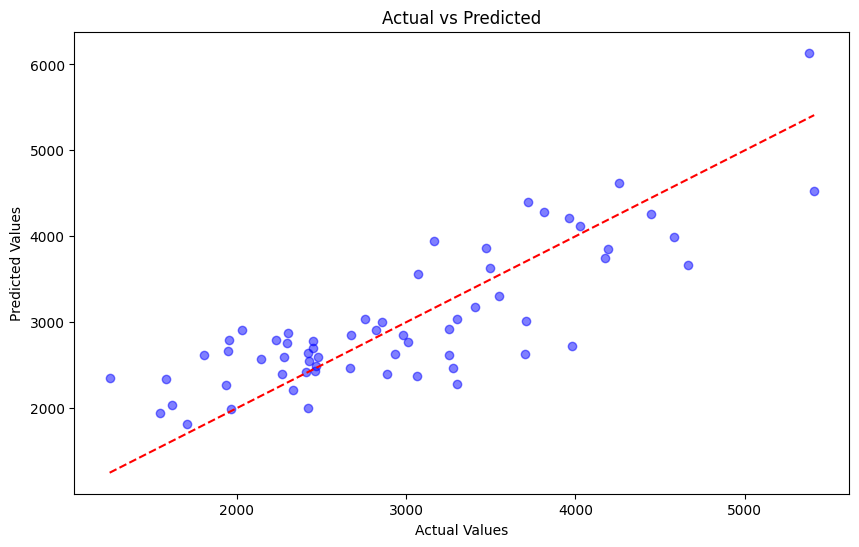

In [82]:
import matplotlib.pyplot as plt

# Dự đoán với mô hình
model.fit(X_train_final, y_train)
y_pred = model.predict(X_test_final)

# Vẽ biểu đồ
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


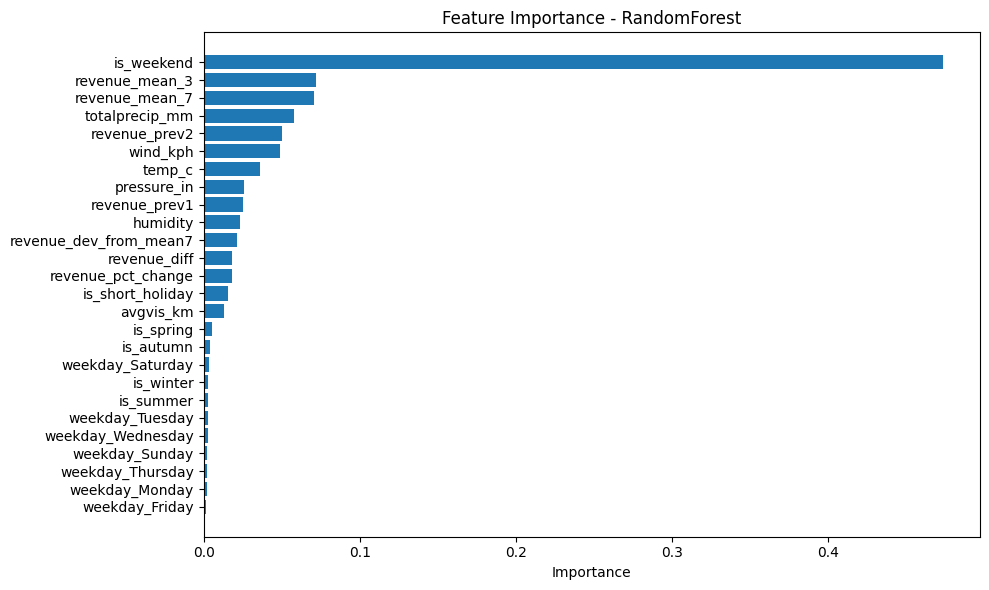

                   Feature  Importance
11              is_weekend    0.473336
20          revenue_mean_3    0.071727
21          revenue_mean_7    0.070410
12          totalprecip_mm    0.058054
19           revenue_prev2    0.050252
15                wind_kph    0.048665
14                  temp_c    0.036332
16             pressure_in    0.026061
18           revenue_prev1    0.025003
17                humidity    0.023428
24  revenue_dev_from_mean7    0.021117
22            revenue_diff    0.018199
23      revenue_pct_change    0.017977
25        is_short_holiday    0.015401
13               avgvis_km    0.012874
7                is_spring    0.005153
9                is_autumn    0.004179
2         weekday_Saturday    0.003555
10               is_winter    0.003037
8                is_summer    0.002860
5          weekday_Tuesday    0.002605
6        weekday_Wednesday    0.002463
3           weekday_Sunday    0.001904
4         weekday_Thursday    0.001877
1           weekday_Monda

In [60]:

import matplotlib.pyplot as plt


# Huấn luyện model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_final, y_train)

# Lấy importance
importances = rf.feature_importances_
feature_names = X_train_final.columns

# Tạo DataFrame để dễ xem
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - RandomForest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# In top 10
print(feat_imp_df)


In [62]:
len(X_train_final.columns)

26

In [65]:
# Giả sử bạn đã có feature_importance_df từ trước

top_n_list =list(range(1, 26, 2))
top_n_list=[23,24,25,26]
 # Số lượng feature muốn chọn
for top_n in top_n_list:
    top_features = feat_imp_df.sort_values(by='Importance', ascending=False).head(top_n)

    # Lấy tên các feature
    top_feature_names = top_features['Feature'].values

    # Lọc dataset của bạn để chỉ còn các feature top
    X_top_features = X_train_final[top_feature_names]  # Lấy X_train với các feature quan trọng nhất
    X_test_top_features = X_test_final[top_feature_names]  # Lấy X_test với các feature quan trọng nhất
    
    # Danh sách mô hình và tên
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'SVR': SVR(kernel='linear')
    }

    # Data đầu vào: X_train_final, y_train, X_test_final, y_test

    results = []

    for name, model in models.items():
        model.fit(X_top_features, y_train)
        y_pred = model.predict(X_test_top_features)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'Model': name,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })

    # In kết quả
    results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
    print(results_df)
    print('-'*50)


              Model         MAE        RMSE        R2
1             Ridge  458.440138  550.864622  0.646393
0  LinearRegression  458.829611  552.742936  0.643977
2             Lasso  458.664577  553.692726  0.642752
3      RandomForest  471.820317  612.988443  0.562139
4           XGBoost  542.701147  710.053953  0.412491
5               SVR  699.195832  848.090167  0.161862
--------------------------------------------------
              Model         MAE        RMSE        R2
1             Ridge  463.750035  558.912949  0.635984
2             Lasso  464.146763  560.303495  0.634171
0  LinearRegression  465.060475  562.490496  0.631309
3      RandomForest  477.517460  617.960407  0.555007
4           XGBoost  545.961957  699.474265  0.429868
5               SVR  698.422657  847.415034  0.163196
--------------------------------------------------
              Model         MAE        RMSE        R2
0  LinearRegression  438.194056  536.600185  0.664469
1             Ridge  439.816636  5